<a href="https://colab.research.google.com/github/10acad-group3/speech_recognition/blob/elias/notebooks/3.0%20speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Recognition


## Imports

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('No GPU.')
else:
  print(gpu_info)

In [256]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16879009962164574527
]


In [3]:
import os
import sys
import cv2
import pickle

import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio

import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import Image
import plotly.graph_objects as go
from tensorflow import keras
import tensorflow.python.keras.utils.vis_utils
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle

from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard

In [4]:
sns.set()
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [5]:
from clean_audio import CleanAudio
from file_handler import FileHandler
from audio_vis import AudioVis
from log_melgram_layer import LogMelgramLayer

In [6]:
clean_audio = CleanAudio()
file_handler = FileHandler()
audio_vis = AudioVis()

## Load Data


In [7]:
# # Vs Code
PATH_Model = "../models/"
PATH_IMG = "../img/"
PATH_TRAIN_WAV = "../data/AMHARIC_CLEAN/train/wav/"
PATH_TEST_WAV = "../data/AMHARIC_CLEAN/test/wav/"
data = pd.read_csv(r'../data/final_data.csv')

## Colab
#from google.colab import drive
#drive.mount('/content/drive')

#!unzip /content/drive/MyDrive/AMHARIC_CLEAN.zip

#PATH_Model = "/content/drive/MyDrive/Models/"
#PATH_IMG = "/content/drive/MyDrive/imgs/"
#PATH_TRAIN_WAV = "/content/AMHARIC_CLEAN/train/wav/"
#PATH_TEST_WAV = "/content/AMHARIC_CLEAN/test/wav/"
#data = pd.read_csv(r'/content/clean_data.csv')

In [8]:
data.head(5)

,Unnamed: 0,key,text,char_length,duration,speed,category
0,0,tr_10300_tr100022,ኢትዮጵያ በገና በ አል ዋዜማ ላይ ኤርትራውያን ን ማባረር ጀመረች ለሚ ለውም ገና ው የ ፈረንጆች ገና ነው,67,6.91,9.69,Train
1,1,tr_10301_tr100023,ከዚያ ወዲህ ሶስት ወር ተጨምሮ እስካሁን ሰባት ሆኗል,33,4.61,7.16,Train
2,2,tr_10302_tr100024,ያን ን ተቋም ነው ወደ ወያኔ ትራንስፖርት ኩባንያ ነት የ ለወጡት ብለዋል,46,4.48,10.27,Train
3,3,tr_10303_tr100025,በ ምዝገባው ወቅት አንዳንዶቹ በ ሰጡት አስተያየት ወደ አገራቸው ለ መመለስ ከፍተኛ ፍላጐት እንዳ ላቸው ገልጸዋል,71,6.78,10.47,Train
4,4,tr_10304_tr100026,ኢትዮጵያውያ ን ከ አስመራ እየ ተባረሩ ነው,27,3.58,7.53,Train


In [9]:
def get_paths(df):
  paths = []
  for col, row in df.iterrows():
    if(row["category"] == "Train"):
      paths.append(PATH_TRAIN_WAV + row["key"] + ".npy")
    else:
      paths.append(PATH_TEST_WAV + row["key"] + ".npy")

  return paths

In [10]:
data["path"] = get_paths(data)
data.sort_values(by=["duration"], inplace=True)
data.reset_index(drop=True, inplace=True)
data = data[["text", "char_length", "duration", "path"]]
data[["text", "char_length", "duration"]]

,text,char_length,duration
0,ሌላው የ ሜዳ ጉዳይ ነው,15,1.60
1,ይሄኔ መለስ ነቃ አለ,13,2.05
2,አንበሳው ስጋ ስላ የ አጉረመረ መ,21,2.11
3,እንስራ ው ተ ሸነቆረ,13,2.18
4,እንስራ ው ተ ሸነቆረ,13,2.18
...,...,...,...
1021,ፕሮጀክቱ ን ለ ማዘጋጀት ና ለ ማቀነባበር እንዲሁም ጥናቱ ንና ዲዛይኑ ን ተግባራዊ ለማድረግ እንዲቻል ከ ሶስቱ ም ሀገሮች የተወጣጡ ባለሙያዎች ን ያሉት ን የ ፕሮጀክት ጽፈት ቤት እንደሚኖር ም ሚኒስትሩ ገልጸዋል,134,14.91
1022,ይሁን ና የ ሶማሌ ላንድ የ ፑትላንድ እንዲሁም ቀሪዎቹ የ ሱማሊያ አንጃዎች ስለ ኢትዮጵያ በ ቦታው ም መገኘት ም ሆነ አድርጋ ለች እያደረገች ም ነው የ ሚባለው እንቅስቃሴ አል ተቃወሙ ም,118,14.98
1023,ከ ለ ቀስተኞቹ መካከል አብዛኛዎቹ ጸሀዩ ዛሬ ተገለጠ ሀይለስላሴ ማሩን አለማችን አባታችን የ አፍሪካ አባት የ አለም አባት በ ማለት ነበር ሀዘና ቸውን የሚገልጹ,101,15.23
1024,በ እስራኤል ኢራቅ ኢራን ን ሩሲያ ሩዋንዳ ማላ ዥያ ሊቢያ ላ ኦስ ስፔን ሶ ሪያ ወዘ ት ጋዜጠኞች እንደ ልብ የ መንቀሳቀሱ እድል እንደሌላ ቸው ድርጅቱ ዘግ ቧል,101,15.36


## Tokenizer

In [11]:
class TokenizerWrap(Tokenizer):
    def __init__(self, texts, padding, len_sent, filters, reverse=False):
        Tokenizer.__init__(self, filters=filters, char_level=True)

        self.len_sent = len_sent
        self.fit_on_texts(texts)

        self.index_to_word = dict(zip(self.word_index.values(), self.word_index.keys()))
        self.tokens = self.texts_to_sequences(texts)

        if reverse:
            self.tokens = [list(reversed(x)) for x in self.tokens]
            truncating = 'pre'
        else:
            truncating = 'post'

        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=len_sent,
                                           padding=padding,
                                           truncating=truncating
                                           )

    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token] for token in tokens if token != 0]
        text = "".join(words)
        return text

    def text_to_tokens(self, text, reverse=False, padding=False):
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            tokens = np.flip(tokens, axis=1)
            truncating = 'pre'
        else:
            truncating = 'post'

        if padding:
            tokens = pad_sequences(tokens,
                                   maxlen=self.len_sent,
                                   padding=truncating,
                                   truncating=truncating
                                   )
        return tokens


In [12]:
MAX_SENTENCE_LENGTH = 134       # The longest sentence in the data is around 150 chars
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n።”፤፦’፥'  # { ።”፤፦’፥' } unique for amharic

In [13]:
%%time
tokenizer = TokenizerWrap(texts=data.text,
                          padding='post',
                          reverse=False,
                          len_sent=MAX_SENTENCE_LENGTH,
                          filters=filters)

Wall time: 176 ms


In [14]:
print(len(tokenizer.word_index))
print(tokenizer.word_index)

215
{' ': 1, 'ን': 2, 'ው': 3, 'ት': 4, 'በ': 5, 'የ': 6, 'አ': 7, 'ስ': 8, 'ለ': 9, 'ል': 10, 'መ': 11, 'ተ': 12, 'ም': 13, 'ር': 14, 'ነ': 15, 'እ': 16, 'ያ': 17, 'ና': 18, 'ይ': 19, 'ች': 20, 'ደ': 21, 'ላ': 22, 'ገ': 23, 'ብ': 24, 'ሰ': 25, 'ሚ': 26, 'ረ': 27, 'ማ': 28, 'ራ': 29, 'ድ': 30, 'ወ': 31, 'ግ': 32, 'ከ': 33, 'ባ': 34, 'ታ': 35, 'ህ': 36, 'ቸ': 37, 'ቀ': 38, 'ጥ': 39, 'ዳ': 40, 'ሆ': 41, 'ጠ': 42, 'ክ': 43, 'ቱ': 44, 'ዋ': 45, 'ሳ': 46, 'ጋ': 47, 'ሁ': 48, 'ጣ': 49, 'ሪ': 50, 'ሉ': 51, 'ካ': 52, 'ኢ': 53, 'ዮ': 54, 'ፈ': 55, 'ዲ': 56, 'ሩ': 57, 'ዘ': 58, 'ፍ': 59, 'ሽ': 60, 'ዎ': 61, 'ሀ': 62, 'ጉ': 63, 'ሮ': 64, 'ቅ': 65, 'ሲ': 66, 'ቆ': 67, 'ቶ': 68, 'ቻ': 69, 'ኛ': 70, 'ጵ': 71, 'ዛ': 72, 'ሎ': 73, 'ሞ': 74, 'ዚ': 75, 'ኮ': 76, 'ኑ': 77, 'ዝ': 78, 'ሊ': 79, 'ቢ': 80, 'ቃ': 81, 'ጅ': 82, 'ቋ': 83, 'ቁ': 84, 'ሬ': 85, 'ኝ': 86, 'ቡ': 87, 'ኩ': 88, 'ጐ': 89, 'ኤ': 90, 'ዜ': 91, 'ኔ': 92, 'ኰ': 93, 'ሱ': 94, 'ኖ': 95, 'ዊ': 96, 'ዬ': 97, 'ፋ': 98, 'ሸ': 99, 'ጀ': 100, 'ቤ': 101, 'ዱ': 102, 'ሙ': 103, 'ቲ': 104, 'ሌ': 105, 'ኳ': 106, 'ፊ': 107, 'ቂ': 108, 'ጊ': 109, 'ፕ': 110, 'ጸ'

In [13]:
data.text[1]

'ይሄኔ መለስ ነቃ አለ'

In [15]:
sample = tokenizer.text_to_tokens(data.text[1], padding=True)
sample

array([[ 19, 126,  92,   1,  11,   9,   8,   1,  15,  81,   1,   7,   9,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [16]:
print(tokenizer.tokens_to_string(sample[0]))

ይሄኔ መለስ ነቃ አለ


save token

In [17]:
with open( str(PATH_Model + 'char_tokenizer_amharic.pickle'), 'wb') as handle:
    pickle.dump(tokenizer, handle)

## Data Augmentation

Next, we can do data augmentation on the raw audio signal by changing the Pitch or Audio Speed and adding noise by a random amount. Data augmentation adds more variety to our input data and helps the model to generalize on a wider range of inputs.

In [18]:
class AudioAugment():
  def __init__(self):
    pass
   
  def change_speed(self, data):
    speed_rate = np.random.uniform(0.8, 1.2)
    wav_speed_tune = cv2.resize(data, (1, int(len(data) * speed_rate))).squeeze()

    if len(wav_speed_tune) < len(data):
      padding = len(data) - len(wav_speed_tune)
      offset = padding // 2
      wav_speed_tune = np.pad(wav_speed_tune, (offset, padding - offset), "constant")
    else:
      wav_speed_tune = wav_speed_tune[:len(data)]

    return wav_speed_tune

  def add_noise(self, data, noise_levels=(0, 0.3)):
    noise_level = np.random.uniform(*noise_levels)
    noise = np.random.randn(len(data))
    data_noise = data + noise_level * noise

    return data_noise

  def change_pitch(self, data):
    n_steps = np.random.randint(-1, 2)
    return librosa.effects.pitch_shift(data, 8000, n_steps)


## DataGenerator


Now that we have completed all the pre - processing steps, we will define a Custom data generation Class using Keras.


Rather than resizing all the audio samples to have the same length by padding them with silence. The class will pad the audio and transcription based on the longest in the batch. Since padding can affect the way the networks function and can make a great deal when it comes to the performance and accuracies of our model. Sorting our data based on duration and generating each bach with small padding will allow us to minimize the downside of padding.

The class returns three augmented versions for a single audio file. Since we are augmenting the audio every time rather than saving the augmented file, our data will change randomly for every batch. For instance, the speed of the audio can speed up or slow down randomly. This will considerably increase the variability in our input data.


In [19]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, sr, batch_size=32, shuffle=True):
        self.data = data      # Data Augmentation
        self.sr = sr
        self.batch_size = batch_size / 4      # Data Augmentation
        self.audio_augment = AudioAugment()
        self.len = int(np.floor(data.shape[0]/ self.batch_size))
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return self.len

    def __data_generation(self, batch_data):

        longest_audio = int(batch_data["duration"].max() * self.sr)
        longest_trans = int(batch_data["char_length"].max())

        X_audio = np.zeros([int(self.batch_size * 4), longest_audio], dtype="float32")
        y_trans = np.ones([int(self.batch_size * 4), longest_trans], dtype="int64")
        X_length = np.ones([int(self.batch_size * 4), 1], dtype="int64") * longest_audio
        y_length = np.zeros([int(self.batch_size * 4), 1], dtype="int64")

        i = 0
        for col, row in batch_data.iterrows():

            # Add transcription
            transcription = tf.convert_to_tensor(tokenizer.text_to_tokens(row["text"], padding=True)[:, :longest_trans])
            y_trans[i,] = y_trans[i + 1,] = y_trans[i + 2,] = y_trans[i + 3,] = transcription
            y_length[i] = y_length[i + 1] = y_length[i + 2] = y_length[i + 3] = row["char_length"]

            # Add original Audio
            audio_length = int(row["duration"] * self.sr)
            wav = np.load(row["path"])[:audio_length]
            X_audio[i, :audio_length] = wav
            i += 1

            # Add noise
            wav_ = self.audio_augment.add_noise(wav)
            X_audio[i, :audio_length] = wav_
            i += 1

            # Add noise
            wav_ = self.audio_augment.add_noise(wav)
            X_audio[i, :audio_length] = wav_
            i += 1

            # # Pitch change
            # wav_ = self.audio_augment.change_pitch(wav)
            # X_audio[i, :audio_length] = wav_
            # i+=1

            # Speed change
            wav_ = self.audio_augment.change_speed(wav)
            X_audio[i, :audio_length] = wav_
            i += 1

        outputs = {'ctc': tf.zeros(([int(self.batch_size * 4)]), dtype=tf.dtypes.float32)}
        inputs = {
            'the_input': tf.convert_to_tensor(X_audio),
            'the_labels': tf.convert_to_tensor(y_trans),
            'input_length': tf.convert_to_tensor(X_length, dtype="float32"),
            'label_length': tf.convert_to_tensor(y_length)
        }
        return (inputs, outputs)

    def on_epoch_end(self):

        self.indexes = np.arange(self.len * self.batch_size)

        if self.shuffle == True:

            self.indexes = self.indexes.reshape(int(self.len), int(self.batch_size))
            np.random.shuffle(self.indexes)

            for i in range(self.len):
                np.random.shuffle(self.indexes[i])

            self.indexes = self.indexes.reshape(int(self.len * self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[int(index * self.batch_size):int((index + 1) * self.batch_size)]
        batch_data = self.data.iloc[indexes]
        return self.__data_generation(batch_data)
    

In [20]:
sr = 8000
batch_size = 128
sample_generator = DataGenerator(data, sr, batch_size, False)

In [21]:
sample_generator.__len__()

32

In [22]:
%%time
sample_data = sample_generator.__getitem__(31)

Wall time: 3.24 s


In [23]:
sample_audios = sample_data[0]["the_input"]
sample_labels = sample_data[0]["the_labels"]
sample_audios_length = sample_data[0]["input_length"]
sample_labels_length = sample_data[0]["label_length"]

In [24]:
print(sample_audios.shape)
print(sample_labels.shape)
print(sample_audios_length.shape)
print(sample_labels_length.shape)

(128, 121856)
(128, 134)
(128, 1)
(128, 1)


In [25]:
sample_labels[0]


<tf.Tensor: shape=(134,), dtype=int64, numpy=
array([ 24, 126,  29,  96,   1,   6,   1,  13,  14, 112,   1, 147,  14,
        30,   1,   5,   1,  12,  21,  47,  47,  26,   1,  28,   8,  42,
         2,  38, 108,  17,   1,  80,   1,  17,   8,  12,  22,  10,  59,
         1,  13,   1,  79,  46,  52,   1,   7,   9,  11,  69,  51,   1,
         2,  18,   1,  16,   2,  21,   1,   3,  13,   1,   5,   1,   7,
        52,  34,  80,   3,   1,  33,   1,  13,  14, 112,   1,  47,  14,
         1,   5,   1,  12,  17,  17,  58,   1,  33,  59,  12,  70,   1,
        20,  32,  14,   1,  16,   2,  40,  19,   1,  33,  25,   4,   1,
         8,  47,  44,   1,   2,   1,  15,   3,   1,   6,   1,  23,   9,
       111,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int64)>

In [25]:
print(tokenizer.tokens_to_string(sample_labels[0].numpy()))
audio_vis.play_audio(sample_audios[0], sr)

ብሄራዊ የ ምርጫ ቦርድ በ ተደጋጋሚ ማስጠንቀቂያ ቢ ያስተላልፍ ም ሊሳካ አለመቻሉ ንና እንደ ውም በ አካባቢው ከ ምርጫ ጋር በ ተያያዘ ከፍተኛ ችግር እንዳይ ከሰት ስጋቱ ን ነው የ ገለጸው


## Log Melgram


The spectrogram is a 2D plot between time and frequency where each point in the plot represents the amplitude of a particular frequency at a particular time in terms of intensity of color. In simple terms, the spectrogram is a spectrum(broad range of colors) of frequencies as it varies with time.

A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time. It uses the Mel Scale instead of Frequency on the y - axis and It uses the Decibel Scale instead of Amplitude to indicate colors.

There is an article on How to Easily Process Audio on Your GPU with TensorFlow by David Schwertfeger. The article describes how to leverage the power of the GPU to process audio data using the TensorFlow signal processor. I have used the code provided in the blog for generating Mel Spectrogram.


In [26]:
def preprocessin_model(fft_size, hop_size, n_mels, mfcc=False):

    input_data = Input(name='input', shape=(None,), dtype="float32")
    spec = LogMelgramLayer(
        num_fft=fft_size,
        hop_length=hop_size,
        num_mels=n_mels,
        sample_rate=sr,
        f_min=0.0,
        f_max=sr // 2,
        eps=1e-6)(input_data)
    x = BatchNormalization(axis=2)(spec)
    # x = Permute((2, 1, 3), name='permute', dtype="float32")(x)
    model = Model(inputs=input_data, outputs=x, name="preprocessin_model")

    return model

### hop_size and  n_mels choise


In [27]:
def compare(i, fft_size, n_mels_list, hop_size_list, sr=16000):

    sample_data = sample_generator.__getitem__(i)
    sample_audios = sample_data[0]["the_input"]
    sample_labels = sample_data[0]["the_labels"]

    nrows, ncols = len(hop_size_list), len(n_mels_list),
    plt.figure(figsize=(4 * nrows, 4 * ncols))

    for i in range(nrows):
        n_mels = n_mels_list[i]

        for y in range(ncols):
            hop_size = hop_size_list[y]

            plt.subplot(nrows, ncols, i * ncols + y + 1)

            model = preprocessin_model(fft_size, hop_size, n_mels)
            pred = model.predict(sample_audios)

            pred = pred[0, :, :, 0]
            librosa.display.specshow(pred.T, sr=sr, hop_length=hop_size, cmap="magma")
            plt.title('hop: {}, n_mels: {}, shape: {}'.format(hop_size, n_mels, pred.shape), fontsize=11)

    print("The longest sentence in this batch has {} characters".format(sample_labels.shape[1]))

    plt.tight_layout()
    plt.show()

The longest sentence in this batch has 77 characters


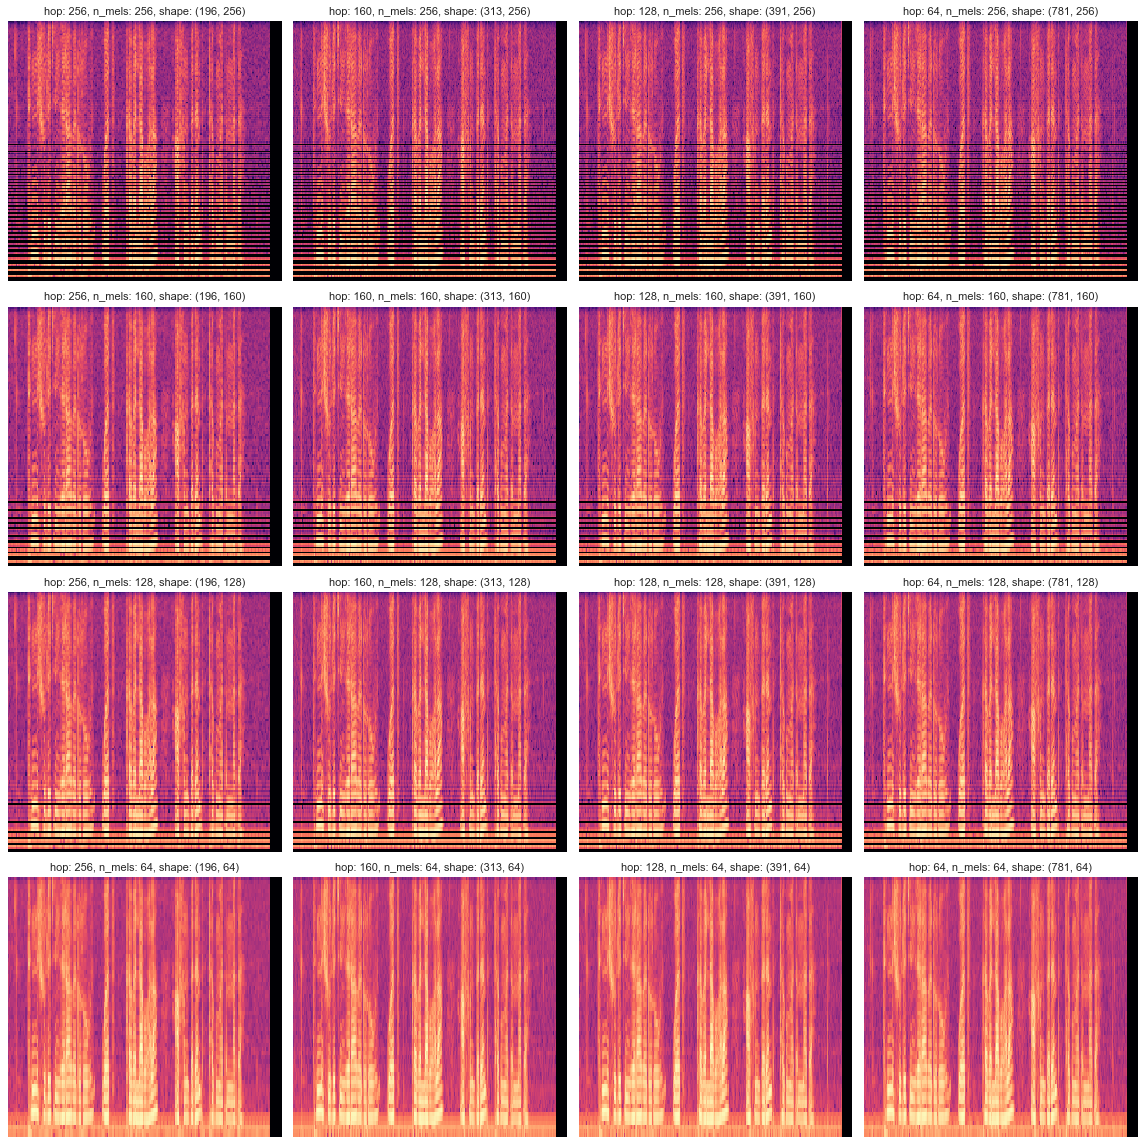

In [28]:
fft_size = 256
n_mels_list = [256, 160, 128, 64]
hop_size_list = [256, 160, 128, 64]
compare(20, fft_size, n_mels_list, hop_size_list, sr)

## Final Choice

In [29]:
fft_size = 256
hop_size = 128
n_mels = 128

In [30]:
melspecModel = preprocessin_model(fft_size, hop_size, n_mels)
melspecModel.summary()

Model: "preprocessin_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
log_melgram_layer_16 (LogMel (None, None, 128, 1)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 128, 1)      512       
Total params: 512
Trainable params: 256
Non-trainable params: 256
_________________________________________________________________


In [31]:
def vis(j=5):
    for i in range(0, 30, 30 // j):
        sample_data = sample_generator.__getitem__(i)
        sample_audios = sample_data[0]["the_input"]
        sample_labels = sample_data[0]["the_labels"]
        sample_labels_length = sample_data[0]["input_length"]

        melspec = melspecModel.predict(sample_audios)

        print('\n')
        print('-' * 100)

        print("The longest sentence in this batch has {} characters".format(sample_labels.shape[1]))
        print("We have to multiply the longest sentence by {} to reach length of Time steps".format(
            np.log2([melspec.shape[1] / sample_labels.shape[1]])[0]))

        print('-' * 100)
        print('\n')

        fig, ax = plt.subplots(figsize=(16, 4))
        pred = melspec[0, :, :, 0]
        vis_model(pred, "Mel-frequency spectrogram")

In [32]:
def vis_model(pred, title, cmap="magma"):
    librosa.display.specshow(pred.T, sr=sr, y_axis='mel', x_axis='time', hop_length=hop_size, cmap=cmap)
    plt.title('{}. Shape = {}'.format(title, pred.shape))
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 29 characters
We have to multiply the longest sentence by 2.52572329734648 to reach length of Time steps
----------------------------------------------------------------------------------------------------




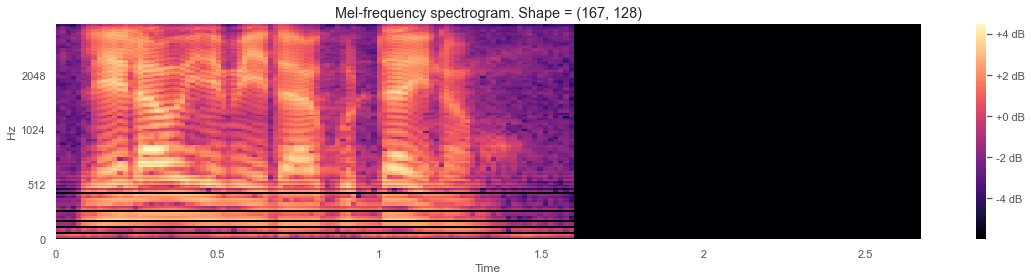



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 40 characters
We have to multiply the longest sentence by 2.626439136697315 to reach length of Time steps
----------------------------------------------------------------------------------------------------




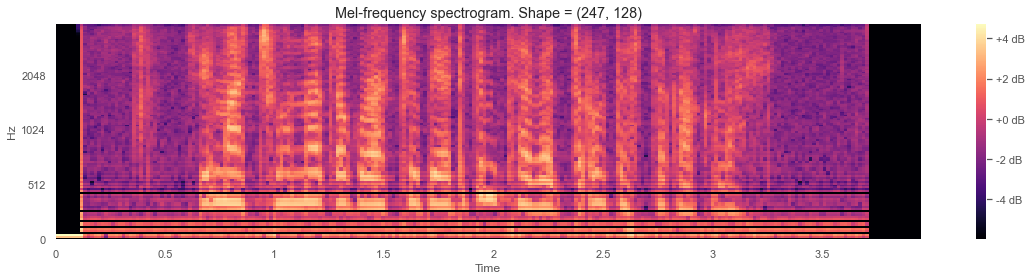



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 55 characters
We have to multiply the longest sentence by 2.423211430724544 to reach length of Time steps
----------------------------------------------------------------------------------------------------




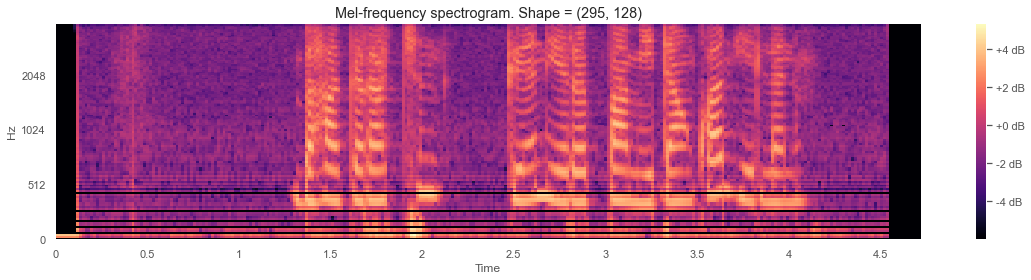



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 61 characters
We have to multiply the longest sentence by 2.557102696260165 to reach length of Time steps
----------------------------------------------------------------------------------------------------




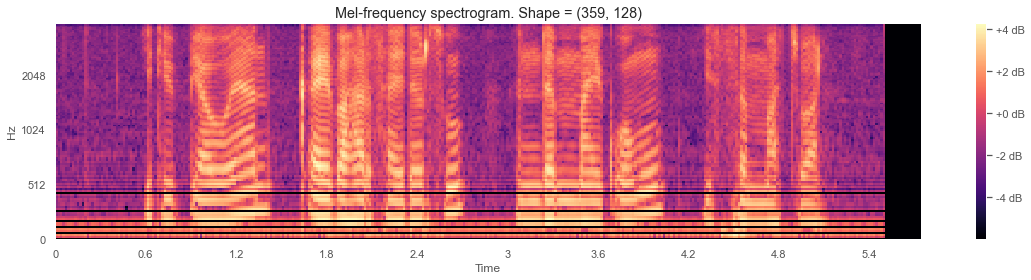



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 87 characters
We have to multiply the longest sentence by 2.4366397537640547 to reach length of Time steps
----------------------------------------------------------------------------------------------------




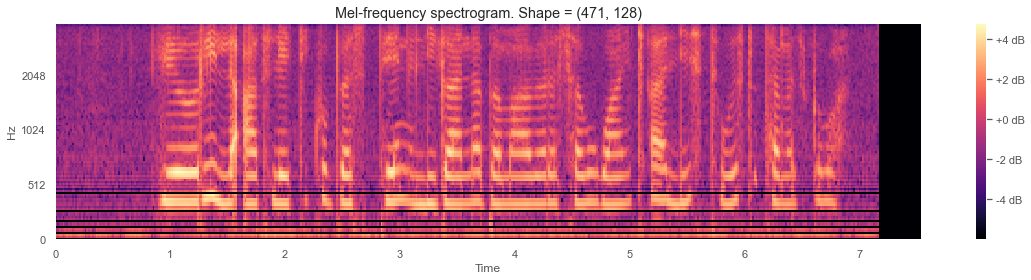

In [33]:
vis(5)

In [33]:
melspec = melspecModel.predict(sample_audios)
melspec.shape

(128, 951, 128, 1)

In [34]:
sample_audios.shape

TensorShape([128, 121856])

## FINAL DATA

In [35]:
shuffled_data = shuffle(data)
shuffled_data.head()

,text,char_length,duration,path
394,እንደ ደንቡ ዳኝነት ተከፍሎ ፋይል ተከፈተ,26,4.61,../data/AMHARIC_CLEAN/train/wav/tr_1094_tr11095.npy
712,የሚደረግ ባቸውን በደል ና ተንኮል በ ቸልታ ያለፉ መስለው ያደ ባሉ,42,6.53,../data/AMHARIC_CLEAN/train/wav/tr_109_tr02009.npy
909,ይህ በ እንዲ ህ እንዳለ የ ደብረ ምጥ ማቅ ቅዱስ ፊልጶስ ቤተ ክርስቲያን ከ ማጡ ወደ ድጡ ሆኖ በት እንደሚ ገኝ ተገለጸ,76,9.47,../data/AMHARIC_CLEAN/train/wav/tr_10545_tr30106.npy
96,ታፈሰ ልብሱ ን ሲያ ጥብ ቆየ,18,3.20,../data/AMHARIC_CLEAN/train/wav/tr_10368_tr100090.npy
658,አሰልጣኙ በ እርግጥ ም ብሄራዊ ቡድኑ ን ከ ያዙ ወዲህ ክለቡ እየ ተሸነፈ ነው,49,6.14,../data/AMHARIC_CLEAN/test/wav/07_d507031.npy


In [36]:
val_point = int(len(data)*.9)
test_point = int(len(data)*.95)
train_data = shuffled_data[:val_point]
val_data = shuffled_data[val_point:test_point]
test_data = shuffled_data[test_point:]

In [37]:
train_data = train_data.sort_values("duration")
val_data = val_data.sort_values("duration")
test_data = test_data.sort_values("duration")

In [38]:
sr = 8000
shuffle = True
batch_size = 32

In [39]:
train_gen = DataGenerator(train_data, sr, batch_size, shuffle)
val_gen = DataGenerator(val_data, sr, batch_size, shuffle)
test_gen = DataGenerator(test_data, sr, batch_size, shuffle)

In [40]:
print(f"Size of train data is {len(train_data)} and batch length is {len(train_gen)}")
print(f"Size of valid data is {len(val_data)}  and batch length is {len(val_gen)}")
print(f"Size of test data is {len(test_data)}  and batch length is {len(test_gen)}")

Size of train data is 923 and batch length is 115
Size of valid data is 51  and batch length is 6
Size of test data is 52  and batch length is 6


## CTC

We will use the CTC loss as the base loss function for our model. CTC is used to align the input and output sequences when the input is continuous and the output is discrete, and there are no clear element boundaries that can be used to map the input to the elements of the output sequence.

The Keras CTC loss function expects y_true, y_pred, input_length, and label_length as an argument. The problem is the input length changes for each batch in our data. We can compute the input length, by dividing the length of the audio by hop size.

The other point is if we are using Convolutional or Max Pooling layers in our model, we need to recompute input length since they can reduce the dimensions of the feature maps.

The final point to keep in mind is the input length(number of time slices) should be greater than two times transcription length plus One. This is mentioned in the CTC paper. Apart from these points, we can calculate CTC loss just by following the documentation from Keras.


In [41]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [42]:
def input_lengths_lambda_func(args):
    input_length = args
    return tf.cast(tf.math.floor(input_length / hop_size)-1, dtype="float32")

In [43]:
x = input_lengths_lambda_func(sample_audios_length[1]).numpy()
x

array([951.], dtype=float32)

In [44]:
def add_ctc_loss(model_builder):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='float32')
    label_lengths = Input(name='label_length', shape=(1,), dtype='float32')

    input_lengths2 = Lambda(input_lengths_lambda_func)(input_lengths)
    if model_builder.output_length:
        output_lengths = Lambda(model_builder.output_length)(input_lengths2)
    else:
        output_lengths = input_lengths2

    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [model_builder.output, the_labels, output_lengths, label_lengths])
    model = Model(inputs=[model_builder.input, the_labels, input_lengths, label_lengths], outputs=loss_out)
    return model

## Model Builder


In [45]:
def build_model(output_dim, custom_model, calc=None):

    input_audios = Input(name='the_input', shape=(None,))
    pre = melspecModel(input_audios)
    pre.trainable = False  # Freeze the layer
    pre = tf.squeeze(pre, [3])

    y_pred = custom_model(pre)
    model = Model(inputs=input_audios, outputs=y_pred, name="model_builder")
    model.output_length = calc

    return model

## Model Trainer

In [46]:
def train(model_builder,
          model_name,
          epochs,
          verbose=1,
          optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
          ):

    model = add_ctc_loss(model_builder)

    # optimizer = Adam(lr=.01, clipnorm = 1, decay=1e-6)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    # print(model.summary())

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath=PATH_Model+model_name+'.h5', verbose=0)
    early_stopping = EarlyStopping( monitor="val_loss", patience=5, restore_best_weights=True)

    # train the model
    hist = model.fit_generator(generator=train_gen,
                               validation_data=val_gen,
                               epochs=epochs,
                               callbacks=[checkpointer, early_stopping],
                               verbose=verbose,
                               use_multiprocessing=False)

    # save model loss
    with open(PATH_Model+model_name+'.pickle', 'wb') as f:
        pickle.dump(hist.history, f)


## Model Inference

In [47]:
from jiwer import wer

In [48]:
def predict(data_gen,  num_elem=1, index=0):
    
    pred_data = data_gen.__getitem__(index)

    pred_audios = pred_data[0]["the_input"]
    pred_labels = pred_data[0]["the_labels"]
    pred_audios_length = pred_data[0]["input_length"]
    
    y_pred = model.predict(pred_audios)

    input_shape = tf.keras.backend.shape(y_pred)
    input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(input_shape[1], 'float32')
    prediction = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=False)[0][0]


    for i in range(0, num_elem):  # only on clean data
        
        pred = K.eval(prediction[i]).flatten().tolist()
        pred = list(filter(lambda a: a != -1, pred))

        ground_truth = tokenizer.tokens_to_string(pred_labels[i].numpy())
        hypothesis   = ''.join(tokenizer.tokens_to_string(pred))
        error        = wer(ground_truth, hypothesis)
                
        print('-'*48 + ' ' + str(i) + ' ' + '-'*48)
        print('True transcription:\n' + '\n' + ground_truth)
        print('-'*100)
        print('Predicted transcription:\n' + '\n' + hypothesis)
        print('-'*100)
        print('Word Error Rate:' + str(error))
        print('\n')

## Simple RNN

In [49]:
def simple_rnn_model(input_dim, output_dim=224):

    input_data = Input(name='the_input', shape=(None, input_dim))

    simp_rnn = GRU(output_dim, return_sequences=True, implementation=2, name='rnn')(input_data)

    y_pred = Activation('softmax', name='softmax')(simp_rnn)

    model = Model(inputs=input_data, outputs=y_pred, name="simple_rnn_model")

    model.output_length = lambda x: x

    return model

In [50]:
simple_rnn_model = simple_rnn_model(128, 224)
# plot_model(simple_rnn_model, to_file='../img/simple_rnn_model.png')
simple_rnn_model.summary()

Model: "simple_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 128)]       0         
_________________________________________________________________
rnn (GRU)                    (None, None, 224)         237888    
_________________________________________________________________
softmax (Activation)         (None, None, 224)         0         
Total params: 237,888
Trainable params: 237,888
Non-trainable params: 0
_________________________________________________________________


In [51]:
model = build_model(len(tokenizer.word_index)+2, simple_rnn_model)
model.summary()

Model: "model_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
preprocessin_model (Function (None, None, 128, 1)      512       
_________________________________________________________________
tf_op_layer_Squeeze (TensorF [(None, None, 128)]       0         
_________________________________________________________________
simple_rnn_model (Functional (None, None, 224)         237888    
Total params: 238,400
Trainable params: 238,144
Non-trainable params: 256
_________________________________________________________________


In [52]:
# import mlflow
# mlflow.set_experiment('speech_recognition')
# mlflow.tensorflow.autolog()
train(model_builder=model, model_name="SimpleRNN_model", epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
115/115 [==============================] - 120s 1s/step - loss: 1295.1005 - val_loss: 1260.8474
Epoch 2/10
115/115 [==============================] - 112s 975ms/step - loss: 1180.7437 - val_loss: 1259.6010
Epoch 3/10
115/115 [==============================] - 110s 954ms/step - loss: 1180.4696 - val_loss: 1259.3060
Epoch 4/10
115/115 [==============================] - 108s 939ms/step - loss: 1180.2926 - val_loss: 1258.6268
Epoch 5/10
115/115 [==============================] - 110s 956ms/step - loss: 1180.0400 - val_loss: 1258.0386
Epoch 6/10
115/115 [==============================] - 110s 956ms/step - loss: 1179.6904 - val_loss: 1257.6167
Epoch 7/10
115/115 [==============================] - 113s 979ms/step - loss: 1179.3556 - val_loss: 1257.5211
Epoch 8/10
115/115 [==============================] - 111s 969ms/step - loss: 1179.2177 - val_loss: 1257.4344
Epoch 9/10
115/115 [===========================

In [53]:
x = predict(test_gen, 1, 0)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
------------------------------------------------ 0 ------------------------------------------------
True transcription:

በሩን እንዲ ህ በ ሀይል አታንኳኲ ብዬ ሽ አልነበር እንዴ
----------------------------------------------------------------------------------------------------
Predicted transcription:

 በ በ በ ን ን ን ን ን ን ን ን ን ን ን ን ን ን ን ን ን ን በ በ 
----------------------------------------------------------------------------------------------------
Word Error Rate:2.3




## CONV_BRNN

$floor(\frac{n-f+2p}{s}+1) $

In [54]:
def cnn_output_length(input_length, kernel_list, pool_sizes, cnn_stride, mx_stride, padding='valid'):

    if padding == 'same':
        output_length = input_length
        
        return output_length

    elif padding == 'valid':

        output_length = input_length
        for i, j, k in zip(kernel_list, pool_sizes, mx_stride):
            output_length = (output_length - i)/cnn_stride + 1
            if j != 0: output_length = (output_length - j)/k + 1
        
        return tf.math.floor(output_length)

In [55]:
def CONV_BRNN( input_dim, filters, kernels, pool_sizes, mx_stride, cnn_stride, output_dim=224, num_cnn = 3, num_birnn = 4 ):

    input_data = Input(name='the_input', shape=(None, input_dim))
    x = Reshape((-1, input_dim, 1), dtype="float32")(input_data)
    
    for i in range(num_cnn):
        x = Conv2D(filters=filters[i], kernel_size=kernels[i], strides=1, padding='valid', name='cnn_{}'.format(i))(x)
        x = LeakyReLU(.1)(x)
        x = MaxPooling2D( pool_size=pool_sizes[i], strides=(1,2), padding="valid")(x)
        x = BatchNormalization(name='bn_cnn_{}'.format(i))(x)
        
    x = Reshape((-1, x.shape[-1] * x.shape[-2] ))(x)

    for i in range(num_birnn):
        x = Bidirectional(GRU(units=512, return_sequences=True, implementation=2, name='rnn_{}'.format(i)))(x)
        x = LeakyReLU(.1)(x)
        x = BatchNormalization(name='bn_rnn_{}'.format(i))(x)
  
    x = TimeDistributed(Dense(output_dim))(x)

    y_pred = Activation('softmax', name='softmax')(x)

    model = Model( inputs=input_data, outputs=y_pred, name="CONV_BRNN" )

    output_length_calculater = lambda x: cnn_output_length(x, kernels, pool_sizes, cnn_stride, mx_stride)
    
    return model, output_length_calculater

In [56]:
filters = [16, 32, 64]
kernels = [7, 5, 3] 
pool_sizes = [3, 3, 3]  
mx_stride = [1, 1, 2]
cnn_stride = 1

In [57]:
CONV_BRNN_Model, calc = CONV_BRNN(n_mels, filters, kernels, pool_sizes, mx_stride, cnn_stride,)
plot_model(CONV_BRNN_Model, to_file=PATH_Model+'CONV_BRNN_Model.png')
CONV_BRNN_Model.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "CONV_BRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 128)]       0         
_________________________________________________________________
reshape (Reshape)            (None, None, 128, 1)      0         
_________________________________________________________________
cnn_0 (Conv2D)               (None, None, 122, 16)     800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, None, 122, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, 60, 16)      0         
_________________________________________________________________
bn_cnn_0 (BatchNormalization (None, None,

In [58]:
model = build_model(len(tokenizer.word_index)+2, CONV_BRNN_Model, calc)
model.summary()

Model: "model_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
preprocessin_model (Function (None, None, 128, 1)      512       
_________________________________________________________________
tf_op_layer_Squeeze_1 (Tenso [(None, None, 128)]       0         
_________________________________________________________________
CONV_BRNN (Functional)       (None, None, 224)         18391072  
Total params: 18,391,584
Trainable params: 18,382,912
Non-trainable params: 8,672
_________________________________________________________________


In [ ]:
train(model_builder=model, model_name="CONV_BRNN_Model", epochs=10)

Epoch 1/10
  2/115 [..............................] - ETA: 1:14:16 - loss: 435.6030

In [ ]:
x = predict(test_gen, 5, 0)

## RESNET

In [ ]:
def cnn_output_length(input_length, kernel_list, pool_sizes, cnn_stride, mx_stride, padding='same'):

    if padding == 'same':        
        output_length = input_length
        for i, j in zip(cnn_stride, pool_sizes):
            output_length = (output_length)/i
            if j != 0: output_length = (output_length - j)/mx_stride + 1
                
        return tf.math.ceil(output_length)

    elif padding == 'valid':

        output_length = input_length
        for i, j in zip(kernel_list, pool_sizes):
            output_length = (output_length - i)/cnn_stride + 1
            if j != 0: output_length = (output_length - j)/mx_stride + 1
        
        return tf.math.floor(output_length)

In [ ]:
def block(filters, inp):
    x = BatchNormalization()(inp)
    x = LeakyReLU(.1)(x)
    x = Dropout(.4)(x)
    x = Conv2D(filters, (3,3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(.1)(x)
    x = Dropout(.4)(x)
    x = Conv2D(filters, (3,3), padding = 'same')(x)
    return(x)

In [ ]:
def resnet( input_dim, output_dim=224, units=256,  num_birnn=2):

    filters = [32, 32, 32]   
    kernels = [3, 3, 3] 
    pool_sizes = [0, 0, 2]  
    cnn_stride = [1, 1, 1]
    mx_stride = 2

    input_data = Input(name='the_input', shape=(None, input_dim))
    x = Reshape((-1, input_dim, 1), dtype="float32")(input_data)
    
    x = Conv2D(filters[0], (3,3), padding = 'same')(x)
    x = MaxPooling2D((1,2), strides=(1, 2), padding = 'same')(x)

    x = Add()([block(filters[0], x),x])  
    x = Add()([block(filters[0], x),x])
    x = Add()([block(filters[0], x),x])

    x = Conv2D(filters[1], (3,3), padding = 'same')(x)
    x = MaxPooling2D((1,2), strides=(1, 2), padding = 'same')(x)
    
    x = Add()([block(filters[1], x),x])
    x = Add()([block(filters[1], x),x])
    x = Add()([block(filters[1], x),x])
    
    x = Conv2D(filters[2], (3,3), padding = 'same')(x)
    x = MaxPooling2D((1,2), strides=(1, 2), padding = 'same')(x)

    x = Add()([block(filters[2], x),x])  
    x = Add()([block(filters[2], x),x])
    x = Add()([block(filters[2], x),x])

    # x = MaxPooling2D((2,2), strides=2, padding = 'same')(x)
    x = AveragePooling2D((2, 2), strides=2, padding='same')(x)
    x = Reshape((-1, x.shape[-1] * x.shape[-2] ))(x)

    # GRULayer
    for i in range(num_birnn):
        x = Bidirectional(GRU(units=units, return_sequences=True, implementation=2, name='rnn_{}'.format(i)))(x)
        x = Dropout(.4)(x)
        x = LeakyReLU(.1)(x)
        x = BatchNormalization(name='bn_rnn_{}'.format(i))(x)

    x = TimeDistributed(Dense(output_dim))(x)
    y_pred = Activation('softmax', name='softmax')(x)

    model = Model( inputs=input_data, outputs=y_pred, name="custom_model" )

    output_length_calculater = lambda x: cnn_output_length(x, kernels, pool_sizes, cnn_stride, mx_stride)
    
    return model, output_length_calculater

In [ ]:
resnet, calc = resnet(n_mels, 224, 512, 4)
# plot_model(resnet, to_file='/content/drive/MyDrive/resnet.png')
resnet.summary()

In [ ]:
model = build_model(len(tokenizer.word_index)+2, resnet, calc)
model.summary()

In [ ]:
# mlflow.set_experiment('Tensorflow')
# mlflow.tensorflow.autolog()
train(model_builder=model, model_name="resnet_Model", epochs=25)

In [ ]:
file = open("/content/resnet_Model.pickle",'rb')
object_file = pickle.load(file)
file.close()

In [ ]:
  def plot_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history['loss'], label="loss")
    plt.plot(history['val_loss'], label="val_loss")
    plt.legend()
    # time = strftime("%Y-%m-%d-%H:%M", gmtime())
    plt.show()

In [ ]:
plot_history(object_file)

In [ ]:
train(model_builder=model, model_name="resnet_new", epochs=50)

In [ ]:
opt = SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
train(model_builder=model, model_name="resnet_v3", epochs=50, optimizer=opt)

In [ ]:
model_name = "resnet_v3"
model.load_weights(PATH_Model + model_name + '.h5')

In [ ]:
x = predict(test_gen, 20, 3)

In [ ]:
x = predict(test_gen, 20, 4)